In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
from dataclasses import dataclass, field
from typing import Callable, Optional
from copy import copy
from itertools import count
from scipy.optimize import minimize
import logging
import time

logging.basicConfig(level=logging.WARNING)
logger = logging.getLogger(__name__)

In [2]:
MIN_LINK_CAPACITY = 50_000
MAX_LINK_CAPACITY = 500_000
MIN_ALLOCATION = 1

MIN_FLOW_SPEED = 50_000
MAX_FLOW_SPEED = 500_000

NUM_LINKS = 2
NUM_FLOWS = 3

def random_link_capacity() -> int:
    return random.randint(MIN_LINK_CAPACITY, MAX_LINK_CAPACITY)

def random_transmission_rate() -> int:
    return random.randint(MIN_FLOW_SPEED, MAX_FLOW_SPEED)

In [3]:
class Link:
    def __init__(self, flows_passing_through: list[int], capacity: int):
        self.flows_passing_through = flows_passing_through
        self.capacity: int = capacity
        self.set_equal_allocations()
        
        # Filled by parent structure
        self.current_rates: dict[int, int] = {}
        
    def set_equal_allocations(self):
        self.allocations = {flow_num: self.capacity // len(self.flows_passing_through) for flow_num in self.flows_passing_through}
    
    
    def validate_allocations(self):
        if sum(self.allocations.values()) > self.capacity:
            raise ValueError("Impossible allocations detected")
            
    def transmission_rate_of(self, flow_num: int) -> Optional[float]:
        if flow_num not in self.flows_passing_through:
            return None
        
        return self.allocations[flow_num]

    def remaining_allocation_resources(self):
        return self.capacity-sum(self.allocations.values())
    
    def runtime(self):
        saturated_flows: list[int] = []
        previous_rates = { flow_num: 0 for flow_num in self.flows_passing_through }
        
        free_resources = 0
        while True:    
            # Detect flow saturation
            speed_differences = {
                flow_num: self.current_rates[flow_num] - previous_rates[flow_num]
                for flow_num in previous_rates.keys()
            }
            
            logger.info("differences %r", speed_differences)
            logger.info("allocations %r", self.allocations)
            logger.info("remaining resources %r", self.remaining_allocation_resources())
            for flow_num in speed_differences:
                if speed_differences[flow_num] == 0 and flow_num not in saturated_flows:
                    logger.info(f"Flow {flow_num} saturation detected")
                    saturated_flows.append(flow_num)
                    unused_allocation = self.allocations[flow_num] - self.current_rates[flow_num]
                    self.allocations[flow_num] -= unused_allocation
                    free_resources += unused_allocation
                    
            if len(saturated_flows) == len(self.flows_passing_through):
                logger.info("ALL FLOWS SATURATED")
                break
                    
            # Give more resources to not saturated flows
            resources_to_transfer_for_each_flow = free_resources // len([flow_num for flow_num in self.flows_passing_through if flow_num not in saturated_flows])
            if resources_to_transfer_for_each_flow > 0:
                for flow_num in self.flows_passing_through:
                    if flow_num not in saturated_flows:
                        logger.info(f"Transferring {resources_to_transfer_for_each_flow} capacity to flow {flow_num}")
                        self.allocations[flow_num] += resources_to_transfer_for_each_flow
                        free_resources -= resources_to_transfer_for_each_flow
            self.validate_allocations()
            
            previous_rates = copy(self.current_rates)
            yield False
            # Hand control back to the network
            # to calculate new transmission speeds
            
        while True:
            yield True


class Flow:
    def __init__(self):             
        self.max_transmission_rate: int = random.randint(MIN_FLOW_SPEED, MAX_FLOW_SPEED)
        # satisfaction_function: Callable[[float], float]


@dataclass
class Network:
    links: list[Link]
    flows: list[Flow]
    global_max_flow_speed: int = 1
    
    def get_speed_of(self, flow_num: int):
        network_bandwidth = min(
            filter(lambda x: x is not None, [link.transmission_rate_of(flow_num) for link in self.links])
        )
        max_rate = self.flows[flow_num].max_transmission_rate
        return min(network_bandwidth, max_rate, self.global_max_flow_speed)
        
    def calculate_transmission_rates(self):
        rates = [self.get_speed_of(index) for index in range(len(self.flows))]
        return rates
    
    def propagate_transmission_rates(self):
        rates = self.calculate_transmission_rates()
        
        for link in self.links:
            for flow_id, rate in enumerate(rates):
                if flow_id in link.flows_passing_through:
                    link.current_rates[flow_id] = rate

    def calculate_utilisation(self) -> float:
        return sum(self.calculate_transmission_rates())
                    
    def format_transmission_rates(self):
        rates = self.calculate_transmission_rates()
        
        return " ".join([ f"{rate}/{flow.max_transmission_rate}" for rate, flow in zip(rates, self.flows) ])

In [4]:
def generate_network(num_links: int, num_flows: int, flow_density: float, link_capacity_generator: Callable[[], float]) -> Network:
    routing_table = []
    flows_passing_through_links = {
        i: [] for i in range(num_links)
    }
    
    # Randomly assign each flow to at least 1 link
    for flow_id in range(num_flows):
        flows_passing_through_links[random.randrange(num_links)].append(flow_id)
    
    for link_id in range(num_links):
        for flow_id in range(num_flows):
            if random.randrange(100)/ 100 < flow_density and flow_id not in flows_passing_through_links[link_id]:
                flows_passing_through_links[link_id].append(flow_id)
    
    links = [Link(flows_passing_through=flows_passing_through_links[link_id], capacity=link_capacity_generator()) for link_id in range(num_links)]
    flows = [Flow() for _ in range(num_flows)]
    
    # print(flows_passing_through_links[0])

    return Network(
        links=links,
        flows=flows
    )


In [5]:
def wellness(allocations, network: Network) -> float:
    num_of_parameters = sum(len(l.flows_passing_through) for l in network.links)
    n.global_max_flow_speed = float('inf')   
    if len(allocations) != num_of_parameters:
        raise ValueError(f"Number of possible allocations does not match the number of parameters: {len(allocations)} != {num_of_parameters}")
        
    allocation_iterator = iter(allocations)
    for link in network.links:
        for i in link.allocations:
            link.allocations[i] = next(allocation_iterator)
    
        sum_of_allocations = sum(link.allocations.values())
        for i in link.allocations:
            link.allocations[i] = link.allocations[i] * link.capacity // sum_of_allocations
            
        # print(link.capacity, link.allocations)
        link.validate_allocations()
        
    return n.calculate_utilisation()


def optimise_solver(n: Network):
    num_params = sum([len(link.flows_passing_through) for link in n.links])
    initial_params = [1 for _ in range(num_params)]
    return minimize(wellness, initial_params, args=(n,), method="SLSQP").fun

# optimise_solver(n)

In [6]:
def optimise_paper_algorithm(n: Network):
    n.global_max_flow_speed = 1
    runtimes = [link.runtime() for link in n.links]  
    for simulation_step in count():
        n.propagate_transmission_rates()
        logger.info("# Transmission rates %s", n.format_transmission_rates())

        rates = n.calculate_transmission_rates()
        # for flow_num, rate in enumerate(rates):
        #     flow_rates_plot[flow_num].append(rate)

        # for link_num in range(len(n.links)):
        #     link_resources_plot[link_num].append(n.links[link_num].remaining_allocation_resources())

        finished_running = []
        for link_num, runtime in enumerate(runtimes):
            logger.info(f"## Link {link_num}")
            finished_running.append(next(runtime))

        logger.info("")

        if all(finished_running):
            return n.calculate_utilisation()

        n.global_max_flow_speed += 1

# Experiment 1

Increasing network density

In [7]:
results_paper = []
results_solver = []

times_paper_1 = []
times_solver_1 = []

network_densities = [i/20 for i in range(20)][1:] # [0.1, 0.25, 0.5, 0.75, 0.9]

for i in network_densities:
    print(i)
    results_paper_temp = []
    results_solver_temp = []
    
    times_paper_temp = []
    times_solver_temp = []
    for _ in range(10):
        n = generate_network(10,20, i, random_link_capacity)
        
        t1 = time.time()
        results_paper_temp.append(optimise_paper_algorithm(n))
        times_paper_temp.append(time.time() - t1)
        
        t1 = time.time()
        results_solver_temp.append(optimise_solver(n))
        times_solver_temp.append(time.time() - t1)
    
    results_paper.append(results_paper_temp)
    results_solver.append(results_solver_temp)
    
    times_paper_1.append(times_paper_temp)
    times_solver_1.append(times_solver_temp)
    

0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.4
0.45
0.5
0.55
0.6
0.65
0.7
0.75
0.8
0.85
0.9
0.95


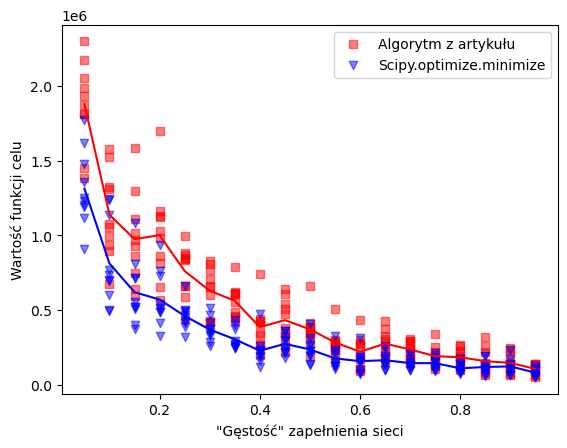

In [8]:
fig, ax = plt.subplots()

results_paper_experiment_1 = results_paper
results_solver_experiment_1 = results_solver

for index, i in enumerate(network_densities):
    for point in results_paper[index]:
        ax.scatter(i, point, c="r", label="Algorytm z artykułu", alpha=0.5, marker="s")

averages = [sum(results_paper[i]) / len(results_paper[i]) for i in range(len(network_densities)) ]
plt.plot(network_densities, averages, c="r", label="Algorytm z artykułu")
 
for index, i in enumerate(network_densities):
    for point in results_solver[index]:
        ax.scatter(i, point, c="b", label="Scipy.optimize.minimize", alpha=0.5, marker="v")
        
averages = [sum(results_solver[i]) / len(results_solver[i]) for i in range(len(network_densities)) ]
plt.plot(network_densities, averages, c="b", label="Scipy.optimize.minimize")
        
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))
    


plt.xlabel('"Gęstość" zapełnienia sieci')
plt.ylabel("Wartość funkcji celu")
# plt.legend()
legend_without_duplicate_labels(ax)
plt.show()

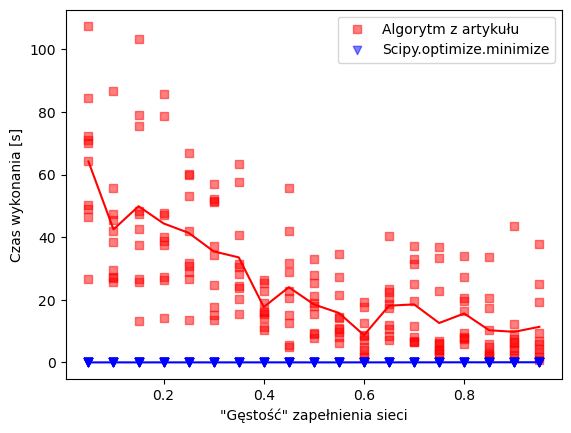

In [9]:
fig, ax = plt.subplots()

for index, i in enumerate(network_densities):
    for point in times_paper_1[index]:
        ax.scatter(i, point, c="r", label="Algorytm z artykułu", alpha=0.5, marker="s")

averages = [sum(times_paper_1[i]) / len(times_paper_1[i]) for i in range(len(network_densities)) ]
plt.plot(network_densities, averages, c="r", label="Algorytm z artykułu")
 
for index, i in enumerate(network_densities):
    for point in times_solver_1[index]:
        ax.scatter(i, point, c="b", label="Scipy.optimize.minimize", alpha=0.5, marker="v")
        
averages = [sum(times_solver_1[i]) / len(times_solver_1[i]) for i in range(len(network_densities)) ]
plt.plot(network_densities, averages, c="b", label="Scipy.optimize.minimize")
        
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))
    


plt.xlabel('"Gęstość" zapełnienia sieci')
plt.ylabel("Czas wykonania [s]")
# plt.legend()
legend_without_duplicate_labels(ax)
plt.show()

# Experiment 2

Different ration between network capacity & flow requirements

In [10]:

results_paper = []
results_solver = []

times_paper_2 = []
times_solver_2 = []

links_vs_flows = [
    (30, 10),
    (25, 15),
    (20, 20),
    (15, 25),
    (10, 30)
]


for num_links, num_flows in links_vs_flows:
    print(i)
    results_paper_temp = []
    results_solver_temp = []
    times_paper_temp = []
    times_solver_temp = []
    
    for _ in range(10):
        n = generate_network(num_links, num_flows, 0.4, random_link_capacity)
        
        t1 = time.time()
        results_paper_temp.append(optimise_paper_algorithm(n))
        times_paper_temp.append(time.time() - t1)
        
        t1 = time.time()
        results_solver_temp.append(optimise_solver(n))
        times_solver_temp.append(time.time() - t1)
        
    
    results_paper.append(results_paper_temp)
    results_solver.append(results_solver_temp)
    times_paper_2.append(times_paper_temp)
    times_solver_2.append(times_solver_temp)



0.95
0.95
0.95
0.95
0.95


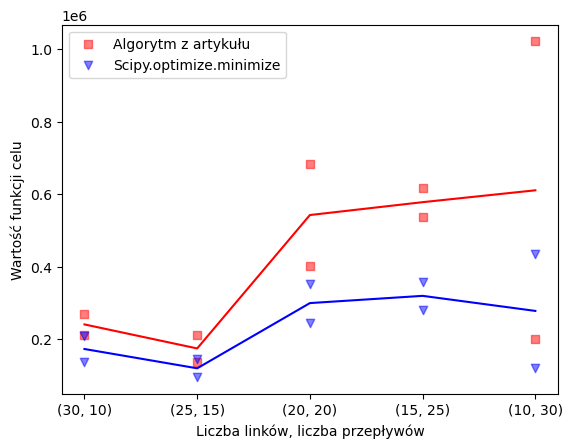

In [11]:
fig, ax = plt.subplots()

results_paper_experiment_2 = results_paper
results_solver_experiment_2 = results_solver

for index, cur_links_vs_flows in enumerate(links_vs_flows):
    for point in results_paper[index]:
        ax.scatter(index, point, c="r", label="Algorytm z artykułu", alpha=0.5, marker="s")

plt.xticks([0, 1, 2, 3, 4], links_vs_flows)
        
averages = [sum(results_paper[i]) / len(results_paper[i]) for i in range(len(links_vs_flows)) ]
plt.plot(range(len(links_vs_flows)), averages, c="r", label="Algorytm z artykułu")
 
for index, cur_links_vs_flows in enumerate(links_vs_flows):
    for point in results_solver[index]:
        ax.scatter(index, point, c="b", label="Scipy.optimize.minimize", alpha=0.5, marker="v")
        
averages = [sum(results_solver[i]) / len(results_solver[i]) for i in range(len(links_vs_flows)) ]
plt.plot(range(len(links_vs_flows)), averages, c="b", label="Scipy.optimize.minimize")
        
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))
    

plt.xlabel('Liczba linków, liczba przepływów')
plt.ylabel("Wartość funkcji celu")
# plt.legend()
legend_without_duplicate_labels(ax)
plt.show()

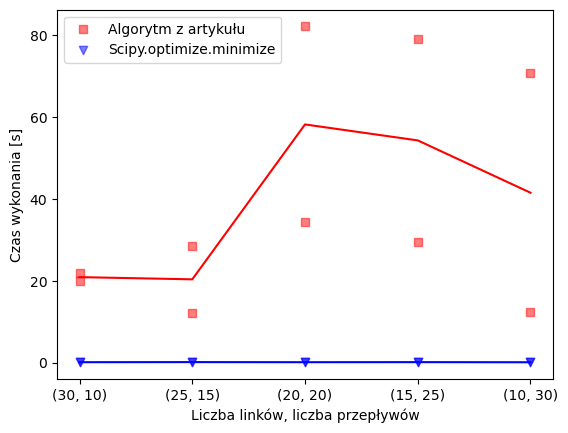

In [12]:
fig, ax = plt.subplots()

for index, cur_links_vs_flows in enumerate(links_vs_flows):
    for point in times_paper_2[index]:
        ax.scatter(index, point, c="r", label="Algorytm z artykułu", alpha=0.5, marker="s")

plt.xticks([0, 1, 2, 3, 4], links_vs_flows)
        
averages = [sum(times_paper_2[i]) / len(times_paper_2[i]) for i in range(len(links_vs_flows)) ]
plt.plot(range(len(links_vs_flows)), averages, c="r", label="Algorytm z artykułu")
 
for index, cur_links_vs_flows in enumerate(links_vs_flows):
    for point in times_solver_2[index]:
        ax.scatter(index, point, c="b", label="Scipy.optimize.minimize", alpha=0.5, marker="v")
        
averages = [sum(times_solver_2[i]) / len(times_solver_2[i]) for i in range(len(links_vs_flows)) ]
plt.plot(range(len(links_vs_flows)), averages, c="b", label="Scipy.optimize.minimize")
        
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))
    

plt.xlabel('Liczba linków, liczba przepływów')
plt.ylabel("Czas wykonania [s]")
# plt.legend()
legend_without_duplicate_labels(ax)
plt.show()

# Experiment 3

Different range of the random network capacity generator

In [13]:
results_paper = []
results_solver = []

times_paper_3 = []
times_solver_3 = []

capacity_ranges = [
    (1, 10),
    (1, 100),
    (1, 200),
    (1, 300),
    (1, 400),
    (1, 500),
    (1, 600),
    (1, 700),
    (1, 800),
    (1, 900),
    (1, 1000),
]


for capacity_min, capacity_max in capacity_ranges:
    print(capacity_min, capacity_max)
    results_paper_temp = []
    results_solver_temp = []
    
    times_paper_temp = []
    times_solver_temp = []
    
    def custom_random_capacity():
        return random.randint(capacity_min, capacity_max)

    for _ in range(10):
        n = generate_network(10, 20, 0.4, custom_random_capacity)
        
        t1 = time.time()
        results_paper_temp.append(optimise_paper_algorithm(n))
        times_paper_temp.append(time.time() - t1)
        
        t1 = time.time()
        results_solver_temp.append(optimise_solver(n))
        times_solver_temp.append(time.time() - t1)
        
    
    results_paper.append(results_paper_temp)
    results_solver.append(results_solver_temp)
    times_paper_3.append(times_paper_temp)
    times_solver_3.append(times_solver_temp)


1 10
1 200
1 400
1 800
1 1000


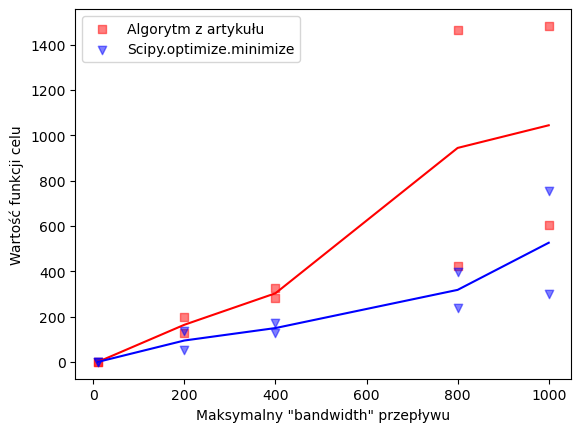

In [14]:
fig, ax = plt.subplots()

results_paper_experiment_3 = results_paper
results_solver_experiment_3 = results_solver

for index, capacity_range in enumerate(capacity_ranges):
    for point in results_paper[index]:
        ax.scatter(capacity_range[1], point, c="r", label="Algorytm z artykułu", alpha=0.5, marker="s")

# plt.xticks([0, 1, 2, 3, 4], links_vs_flows)
        
averages = [sum(results_paper[i]) / len(results_paper[i]) for i in range(len(capacity_ranges)) ]
plt.plot([x[1] for x in capacity_ranges], averages, c="r", label="Algorytm z artykułu")
 
for index, capacity_range in enumerate(capacity_ranges):
    for point in results_solver[index]:
        ax.scatter(capacity_range[1], point, c="b", label="Scipy.optimize.minimize", alpha=0.5, marker="v")
        
averages = [sum(results_solver[i]) / len(results_solver[i]) for i in range(len(capacity_ranges)) ]
plt.plot([x[1] for x in capacity_ranges], averages, c="b", label="Scipy.optimize.minimize")
        
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))
    


plt.xlabel('Maksymalny "bandwidth" przepływu')
plt.ylabel("Wartość funkcji celu")
# plt.legend()
legend_without_duplicate_labels(ax)
plt.show()

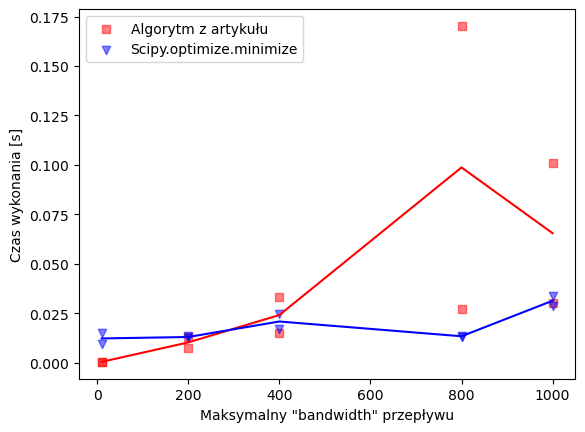

In [15]:
fig, ax = plt.subplots()


for index, capacity_range in enumerate(capacity_ranges):
    for point in times_paper_3[index]:
        ax.scatter(capacity_range[1], point, c="r", label="Algorytm z artykułu", alpha=0.5, marker="s")

# plt.xticks([0, 1, 2, 3, 4], links_vs_flows)
        
averages = [sum(times_paper_3[i]) / len(times_paper_3[i]) for i in range(len(capacity_ranges)) ]
plt.plot([x[1] for x in capacity_ranges], averages, c="r", label="Algorytm z artykułu")
 
for index, capacity_range in enumerate(capacity_ranges):
    for point in times_solver_3[index]:
        ax.scatter(capacity_range[1], point, c="b", label="Scipy.optimize.minimize", alpha=0.5, marker="v")
        
averages = [sum(times_solver_3[i]) / len(times_solver_3[i]) for i in range(len(capacity_ranges)) ]
plt.plot([x[1] for x in capacity_ranges], averages, c="b", label="Scipy.optimize.minimize")
        
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))
    


plt.xlabel('Maksymalny "bandwidth" przepływu')
plt.ylabel("Czas wykonania [s]")
# plt.legend()
legend_without_duplicate_labels(ax)
plt.show()

In [16]:

# flow_rates_plot = [[] for _ in range(len(n.flows))]
# link_resources_plot = [[] for _ in range(len(n.links)) ]
# simulation_steps = []

# n.global_max_flow_speed = 1
# runtimes = [link.runtime() for link in n.links]  
# for simulation_step in count():
#     simulation_steps.append(simulation_step)
#     n.propagate_transmission_rates()
#     logger.info("# Transmission rates %s", n.format_transmission_rates())
    
    
#     rates = n.calculate_transmission_rates()
#     for flow_num, rate in enumerate(rates):
#         flow_rates_plot[flow_num].append(rate)
        
#     for link_num in range(len(n.links)):
#         link_resources_plot[link_num].append(n.links[link_num].remaining_allocation_resources())
    
#     finished_running = []
#     for link_num, runtime in enumerate(runtimes):
#         logger.info(f"## Link {link_num}")
#         finished_running.append(next(runtime))
        
#     logger.info("")
    
#     if all(finished_running):
#         break

#     n.global_max_flow_speed += 1
    
# print("ALL LINKS FINISHED RUNNING")
# print("# Transmission rates", n.format_transmission_rates())
# print("# Utilisation", n.calculate_utilisation())

In [17]:
for flow_num, flow_data in enumerate(flow_rates_plot):
    plt.plot(flow_data, label=f"Flow {flow_num}")

for link_num, resources in enumerate(link_resources_plot):
    plt.plot(resources, linestyle='dotted', label=f"Link {flow_num} resources")
    
plt.legend(loc="upper left")
plt.show()

NameError: name 'flow_rates_plot' is not defined